In [1]:
# benchmarking the non-balanced strategies for comparison
# -NEI
# -TEAD
# -TuRBO - todo
# - Sobol
# Author: Alex Braafladt
# Created 3/5/2023
# Notes:

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from extremasearch.globalmm.globalsearch import MultimodalExtremaSearch
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
import networkx as nx
from botorch.models.transforms import Normalize, Standardize


# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
# setup file i/o
import os as os
import datetime as dt
# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'mme_nonbalanced_benchmark_nd' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\extrema_search\src\notebooks
Data save directory: C:\Users\alexb\PycharmProjects\extrema_search\src\notebooks\output\\mme_nonbalanced_benchmark_nd20230306094914


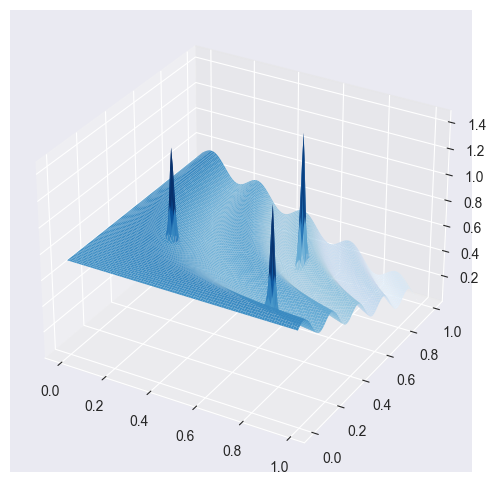

In [85]:
# and with addition of smooth global behavior
def mme_add_2d_plot(x1, x2):
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = mme_add_2d_plot(X1, X2)
from matplotlib import ticker, cm
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))

from matplotlib.colors import LightSource
ls = LightSource(270, 45)
rgb = ls.shade(Z.numpy(), cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)
# surf = ax.plot_surface(X1, X2, Z, facecolors=rgb, shade=False)
plt.savefig(datasavedir + '/'+'2d_mme_attempt'+'.png')

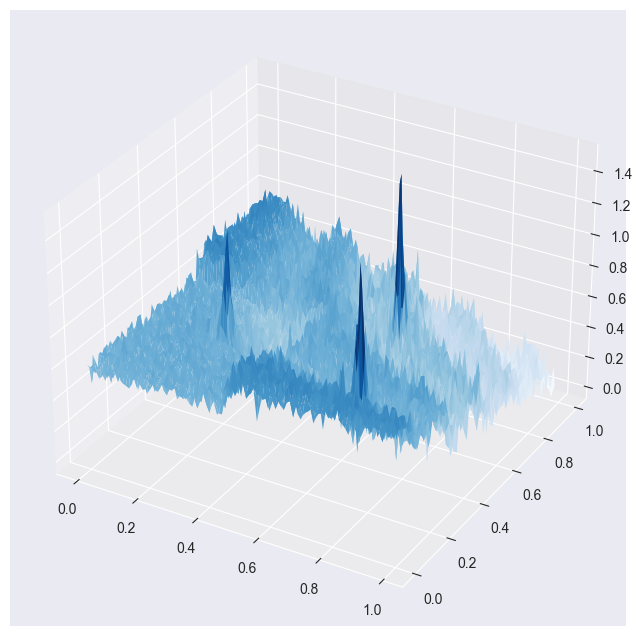

In [86]:
sigma_max = 0.12
sigma_min = 0.02
def noise_1_2d(x1, x2):
    # mean
    y = mme_add_2d_plot(x1, x2)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)
plt.savefig(datasavedir + '/'+'2d_mme_noise_attempt1'+'.png')

In [87]:
sigma_max = 0.12
sigma_min = 0.02
def mme_add_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

def mme_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    # mean
    y = mme_add_2d(X)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    return mme_2d(x).type_as(x).unsqueeze(-1)

In [7]:
# testing loop functions
test_train_x = torch.rand(10, 2, dtype=dtype)
test_obj = outcome_objective(test_train_x)
best_observed_value = test_obj.max().item()

In [8]:
# set up the GP model for use
def initialize_model(train_x, train_obj, state_dict=None):
    """function to initialize the GP model"""
    model_obj = SingleTaskGP(train_x, train_obj)
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state_dict if it is not passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

# set up the initial data set
def generate_initial_data(n=10):
    """generate initial set of data to get started with BO loop"""
    train_x = torch.rand(10, 2, device=device, dtype=dtype)
    exact_obj = outcome_objective(train_x)
    train_obj = exact_obj
    best_observed_value = exact_obj.max().item()
    return train_x, train_obj, best_observed_value

from botorch.optim import optimize_acqf
NUM_RESTARTS = 10
RAW_SAMPLES = 512
bounds = torch.tensor([[0.0, 1.0],[0.0, 1.0]], device=device, dtype=dtype)
def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation"""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,# initialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = candidates.detach()
    new_obj = outcome_objective(new_x)
    return new_x, new_obj

def update_random_observation():
    """Simulates a random policy by taking the current list of best values observed
    randomly, drawing a new random point, observing its value, and updating the list
    """
    rand_x = torch.rand(BATCH_SIZE, 2)  # drawing from random uniform
    next_random_best = outcome_objective(rand_x)
    return  rand_x, next_random_best

In [9]:
# metrics functions - todo make update for 2d problem
def count_number_peaks_observed_2d(x_obs, y_obs, num_known_peaks=4):
    """Function to count the number of peaks observed for the mme_noise_jump_1d function"""
    peak1, peak2, peak3, peak4 = False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.03 <= x <= 0.07:
            if y >= 1.065:
                peak1 = True
        elif 0.345 <= x <= 0.355:
            if y >= 1.12:
                peak2 = True
        elif 0.645 <= x <= 0.655:
            if y >= 1.145:
                peak3 = True
        elif 0.915 <= x <= 0.925:
            if y >= 0.734:
                peak4 = True
    num_peaks_observed = peak1 + peak2 + peak3 + peak4
    return num_peaks_observed


def count_evaluations_for_all_peaks_2d(x_obs, y_obs):
    """Count the number of function evaluations before finding all peaks"""
    i = 0
    num_evals_for_all_peaks = x_obs.shape[0]
    peak1, peak2, peak3, peak4 = False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.03 <= x <= 0.07:
            if y >= 1.065:
                peak1 = True
        elif 0.345 <= x <= 0.355:
            if y >= 1.12:
                peak2 = True
        elif 0.645 <= x <= 0.655:
            if y >= 1.145:
                peak3 = True
        elif 0.915 <= x <= 0.925:
            if y >= 0.734:
                peak4 = True
        i += 1
        if peak1 and peak2 and peak3 and peak4:
            num_evals_for_all_peaks = i
            break
    return num_evals_for_all_peaks

In [79]:
from extremasearch.acquisition.turbo import NewTurboState, new_update_state, generate_batch
from extremasearch.acquisition.tead import global_tead
from extremasearch.acquisition.qtead import nglobal_tead
import time
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.monte_carlo import qNoisyExpectedImprovement
from extremasearch.local.localsearch import initialize_scaled_model

N_TRIALS = 1
N_BATCH = 200 # note +10 for total iteration limit
MC_SAMPLES = 256
dim = 2
N_CANDIDATES = min(5000, max(2000, 200 * dim))
BATCH_SIZE = 1

verbose = True
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# set up arrays to hold arrays of data
# best values
best_observed_all_nei, best_observed_random_all, best_observed_all_tead = [], [], []
# best_observed_all_turbo = []
# {x, y} values
x_observed_all_random, x_observed_all_nei, x_observed_all_tead = [], [], []
y_observed_all_random, y_observed_all_nei, y_observed_all_tead = [], [], []
# x_observed_all_turbo = []
# y_observed_all_turbo = []

# mmo results
# todo add back in when metric functions updated to nd
# distinct_peaks_random, distinct_peaks_nei, distinct_peaks_tead = [], [], []
# function_evals_random, function_evals_nei, function_evals_tead = [], [], []
# distinct_peaks_turbo = []
# function_evals_turbo = []

# going to average over N_TRIALS
for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    # set up arrays to hold data for this trial
    best_observed_nei, best_observed_random, best_observed_tead = [], [], []
    # best_observed_turbo = []

    # generate initial training data and initial model for this trial
    # nei
    # use same initial training points
    train_x_nei, train_obj_nei, best_observed_value_nei = generate_initial_data(n=10)
    mll_nei, model_nei = initialize_model(train_x_nei, train_obj_nei)
    # tead
    # use same initial points
    train_x_tead, train_obj_tead = train_x_nei, train_obj_nei
    best_observed_value_tead = best_observed_value_nei
    mll_tead, model_tead = initialize_model(train_x_tead, train_obj_tead)
    # turbo
    # train_x_turbo, train_obj_turbo = train_x_nei, train_obj_nei
    # best_observed_value_turbo = best_observed_value_nei
    # turbo initialization
    # state = NewTurboState(dim=1, batch_size=BATCH_SIZE, center=torch.tensor(0.5), lb=torch.tensor(0.0), ub=torch.tensor(1.0))
    # state = new_update_state(state, train_x_turbo, train_obj_turbo, torch.DoubleTensor([best_observed_value_turbo]))
    # tr_x_turbo, tr_obj_turbo = state.get_training_samples_in_region()
    # mll_turbo, model_turbo = initialize_scaled_model(tr_x_turbo, tr_obj_turbo)
    # random
    train_x_random, train_obj_random = train_x_nei, train_obj_nei

    # start collection of results from random initialization
    best_observed_nei.append(best_observed_value_nei)
    best_observed_random.append(best_observed_value_nei)
    best_observed_tead.append(best_observed_value_tead)
    # best_observed_turbo.append(best_observed_value_turbo)

    # for N_BATCH rounds of BO after the initial random batch
    for iteration in range(1, N_BATCH + 1):
        t0 = time.monotonic()
        # fit models
        fit_gpytorch_mll(mll_nei)
        fit_gpytorch_mll(mll_tead)
        # fit_gpytorch_mll(mll_turbo)

        # set up the sampler to use with the acq funcs
        qmc_sampler = SobolQMCNormalSampler(sample_shape=MC_SAMPLES)

        # set up the acquisition functions
        qNEI = qNoisyExpectedImprovement(
            model=model_nei,
            X_baseline=train_x_nei,
            sampler=qmc_sampler,
        )

        # optimize the acquisition functions
        new_x_nei, new_obj_nei = optimize_acqf_and_get_observation(qNEI)
        new_x_tead = nglobal_tead(model_tead)
        new_obj_tead = outcome_objective(new_x_tead)
        # new_x_turbo = generate_batch(
        #     state=state,
        #     model=model_turbo,
        #     # x=train_x_turbo,
        #     x=state.train_x,
        #     # y=train_obj_turbo,
        #     y=state.train_y,
        #     batch_size=BATCH_SIZE,
        #     n_candidates=N_CANDIDATES,
        #     num_restarts=NUM_RESTARTS,
        #     raw_samples=RAW_SAMPLES,
        #     acqf='ts',
        #     # acqf='ei',
        # )
        # new_obj_turbo = outcome_objective(new_x_turbo)
        # random
        new_x_random, new_obj_random = update_random_observation()

        # update training points
        train_x_nei = torch.cat([train_x_nei, new_x_nei])
        train_obj_nei = torch.cat([train_obj_nei, new_obj_nei])
        train_x_tead = torch.cat([train_x_tead, new_x_tead])
        train_obj_tead = torch.cat([train_obj_tead, new_obj_tead])
        # train_x_turbo = torch.cat([train_x_turbo, new_x_turbo])
        # train_obj_turbo = torch.cat([train_obj_turbo, new_obj_turbo])
        train_x_random = torch.cat([train_x_random, new_x_random])
        train_obj_random = torch.cat([train_obj_random, new_obj_random])

        # update trust region
        # state = new_update_state(state, x_train=train_x_turbo, y_train=train_obj_turbo, y_next=new_obj_turbo)

        # update progress data
        best_value_random = train_obj_random.max()
        best_observed_random.append(best_value_random)
        best_value_nei = train_obj_nei.max()
        best_observed_nei.append(best_value_nei)
        best_value_tead = train_obj_tead.max()
        best_observed_tead.append(best_value_tead)
        # best_value_turbo = train_obj_turbo.max()
        # best_observed_turbo.append(best_value_turbo)

        # reinitialize the models so that they're ready to fit on the next iteration
        # state dict passed to speed up fitting
        mll_nei, model_nei = initialize_model(
            train_x_nei,
            train_obj_nei,
            model_nei.state_dict(),
        )
        mll_tead, model_tead = initialize_model(
            train_x_tead,
            train_obj_tead,
            model_tead.state_dict(),
        )
        # update trust region model
        # tr_x_turbo, tr_obj_turbo = state.get_training_samples_in_region()
        # mll_turbo, model_turbo = initialize_scaled_model(tr_x_turbo, tr_obj_turbo)

        t1 = time.monotonic()

        if verbose:
            print(
                # f"\nBatch {iteration:>2}: best_value (random, qNEI, TEAD, TuRBO) = "
                # f"({best_value_random:>4.2f}, {best_value_nei:>4.2f}, {best_value_tead:>4.2f}, {state.best_value:>4.2f}), "
                f"\nBatch {iteration:>2}: best_value (random, qNEI, TEAD) = "
                f"({best_value_random:>4.2f}, {best_value_nei:>4.2f}, {best_value_tead:>4.2f},), "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

    # collect observations from trial
    best_observed_all_nei.append(best_observed_nei)
    best_observed_random_all.append(best_observed_random)
    best_observed_all_tead.append(best_observed_tead)
    # best_observed_all_turbo.append(best_observed_turbo)
    x_observed_all_random.append(train_x_random)
    x_observed_all_nei.append(train_x_nei)
    x_observed_all_tead.append(train_x_tead)
    # x_observed_all_turbo.append(train_x_turbo)
    y_observed_all_random.append(train_obj_random)
    y_observed_all_nei.append(train_obj_nei)
    y_observed_all_tead.append(train_obj_tead)
    # y_observed_all_turbo.append(train_obj_turbo)
    # todo once metric functions updated to 2d
    # # collect metrics
    # distinct_peaks_random.append(count_number_peaks_observed(train_x_random, train_obj_random))
    # distinct_peaks_nei.append(count_number_peaks_observed(train_x_nei, train_obj_nei))
    # distinct_peaks_tead.append(count_number_peaks_observed(train_x_tead, train_obj_tead))
    # # distinct_peaks_turbo.append(count_number_peaks_observed(train_x_turbo, train_obj_turbo))
    # function_evals_random.append(count_evaluations_for_all_peaks(train_x_random, train_obj_random))
    # function_evals_nei.append(count_evaluations_for_all_peaks(train_x_nei, train_obj_nei))
    # function_evals_tead.append(count_evaluations_for_all_peaks(train_x_tead, train_obj_tead))
    # # function_evals_turbo.append(count_evaluations_for_all_peaks(train_x_turbo, train_obj_turbo))


Trial  1 of 1 
Batch  1: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.80,), time = 12.69.
Batch  2: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.80,), time = 8.48.
Batch  3: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.80,), time = 8.67.
Batch  4: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.80,), time = 7.61.
Batch  5: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.86,), time = 8.05.
Batch  6: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.86,), time = 8.28.
Batch  7: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.86,), time = 7.84.
Batch  8: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.86,), time = 8.53.
Batch  9: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.86,), time = 8.39.
Batch 10: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.86,), time = 7.73.
Batch 11: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.86,), time = 7.70.
Batch 12: best_value (random, qNEI, TEAD) = (0.80, 0.80, 0.86,), time = 7.34.
Batch 13: best_value (random, qNEI, TEAD) = (0.

In [80]:
# abbreviated QMC loop with Sobol sequences
from torch.quasirandom import SobolEngine

best_observed_all_sobol = []
x_observed_all_sobol, y_observed_all_sobol = [], []
distinct_peaks_sobol = []
function_evals_sobol = []
for trial in range(1, N_TRIALS + 1):
    print(f"\nSobol Trial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_sobol = []
    # get sobol random samples for the trial
    X_Sobol = SobolEngine(dimension=2, scramble=True).draw(N_BATCH+10).to(dtype=dtype, device=device)
    Y_Sobol = torch.tensor([outcome_objective(x) for x in X_Sobol], dtype=dtype, device=device)
    curMax = torch.max(Y_Sobol[:10])
    for y_val in Y_Sobol[10:]:
        curMax = torch.max(curMax,y_val)
        best_observed_sobol.append(curMax.squeeze())
    best_observed_all_sobol.append(best_observed_sobol)
    x_observed_all_sobol.append(X_Sobol)
    y_observed_all_sobol.append(Y_Sobol)
    # distinct_peaks_sobol.append(count_number_peaks_observed(X_Sobol, Y_Sobol))
    # function_evals_sobol.append(count_evaluations_for_all_peaks(X_Sobol, Y_Sobol))


Sobol Trial  1 of 1 

In [13]:
# collect output data
# calculate summary metrics
# peak ratio
num_known_peaks = 4
peak_ratio_random = sum(distinct_peaks_random) / (num_known_peaks * N_TRIALS)
peak_ratio_nei = sum(distinct_peaks_nei) / (num_known_peaks * N_TRIALS)
peak_ratio_tead = sum(distinct_peaks_tead) / (num_known_peaks * N_TRIALS)
peak_ratio_turbo = sum(distinct_peaks_turbo) / (num_known_peaks * N_TRIALS)
peak_ratio_sobol = sum(distinct_peaks_sobol) / (num_known_peaks * N_TRIALS)
print(f"Peak ratio: Random {peak_ratio_random:>4.2f}, NEI {peak_ratio_nei:>4.2f}, TEAD {peak_ratio_tead:>4.2f}, TuRBO {peak_ratio_turbo:>4.2f}, QMC {peak_ratio_sobol:>4.2f} ")
# success rate
num_successes_random = 0
num_successes_nei = 0
num_successes_tead = 0
num_successes_turbo = 0
num_successes_sobol = 0
for i in range(N_TRIALS):
    if distinct_peaks_random[i] == 4:
        num_successes_random += 1
    if distinct_peaks_nei[i] == 4:
        num_successes_nei += 1
    if distinct_peaks_tead[i] == 4:
        num_successes_tead += 1
    if distinct_peaks_turbo[i] == 4:
        num_successes_turbo += 1
    if distinct_peaks_sobol[i] == 4:
        num_successes_sobol += 1
success_ratio_random = num_successes_random / N_TRIALS
success_ratio_nei = num_successes_nei / N_TRIALS
success_ratio_tead = num_successes_tead / N_TRIALS
success_ratio_turbo = num_successes_turbo / N_TRIALS
success_ratio_sobol = num_successes_sobol / N_TRIALS
print(f"Success ratio: Random {success_ratio_random:>4.2f}, NEI {success_ratio_nei:>4.2f}, TEAD {success_ratio_tead:>4.2f}, TuRBO {success_ratio_turbo:>4.2f}, Sobol {success_ratio_sobol:>4.2f}")
# function evaluations
fe_random = sum(function_evals_random)/N_TRIALS
fe_nei = sum(function_evals_nei)/N_TRIALS
fe_tead = sum(function_evals_tead)/N_TRIALS
fe_turbo = sum(function_evals_turbo)/N_TRIALS
fe_sobol = sum(function_evals_sobol)/N_TRIALS
print(f"Average function evaluations: Random {fe_random}, NEI {fe_nei}, TEAD {fe_tead}, TuRBO {fe_turbo}, Sobol {fe_sobol}")

Peak ratio: Random 0.52, NEI 0.48, TEAD 0.70, TuRBO 0.27, QMC 0.57 
Success ratio: Random 0.00, NEI 0.00, TEAD 0.13, TuRBO 0.00, Sobol 0.07
Average function evaluations: Random 129.0, NEI 129.0, TEAD 125.2, TuRBO 129.0, Sobol 125.6


In [81]:
y_tead = np.asarray(best_observed_all_tead)
y_sobol = np.asarray(best_observed_all_sobol)

In [82]:
fit_gpytorch_mll(mll_nei)
fit_gpytorch_mll(mll_tead)
# fit_gpytorch_mll(mll_turbo)
None

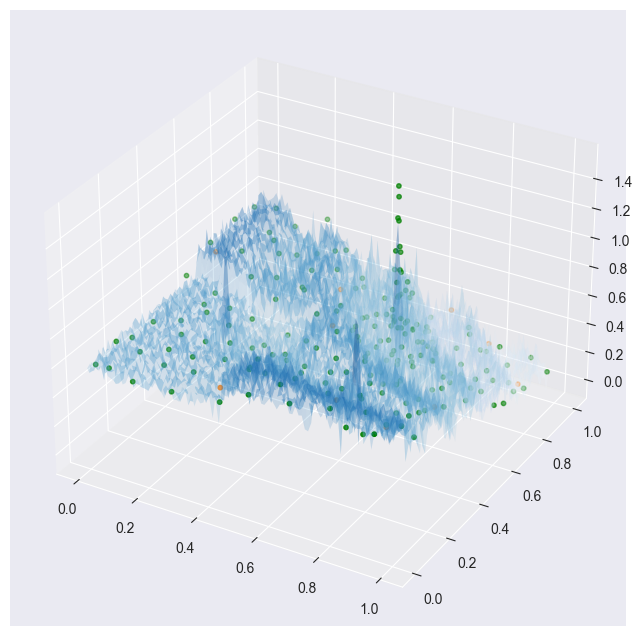

In [83]:
# plot evaluations for tead - surface
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0, alpha=0.2)
ax.scatter(train_x_tead[:,0].numpy()[0:10], train_x_tead[:,1].numpy()[0:10], train_obj_tead.numpy()[0:10], marker='.', color='tab:orange', s=40)
ax.scatter(train_x_tead[:,0].numpy()[10:], train_x_tead[:,1].numpy()[10:], train_obj_tead.numpy()[10:], marker='.', color='g', s=40)
plt.savefig(datasavedir + '/'+'2d_mme_noise_tead_evals'+'.png')

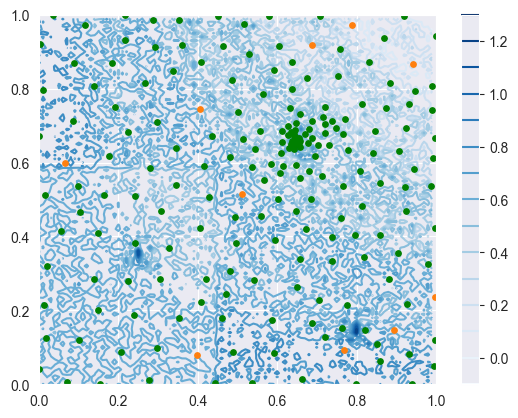

In [84]:
# plot evaluations for tead contour
fig1, ax1 = plt.subplots()
CS = ax1.contour(X1, X2, Z, levels=15, cmap='Blues')
cbar = fig1.colorbar(CS)
# ax1.autoscale(False)
ax1.scatter(train_x_tead[:,0].numpy()[0:10], train_x_tead[:,1].numpy()[0:10], s=15, marker='o', color='tab:orange', zorder=2)
ax1.scatter(train_x_tead[:,0].numpy()[10:], train_x_tead[:,1].numpy()[10:], s=15, marker='o', color='g', zorder=2)
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
plt.savefig(datasavedir + '/'+'2d_mme_noise_tead_evals_contour'+'.png')

In [41]:
train_obj_tead.numpy()[0:10].shape

(10, 1)

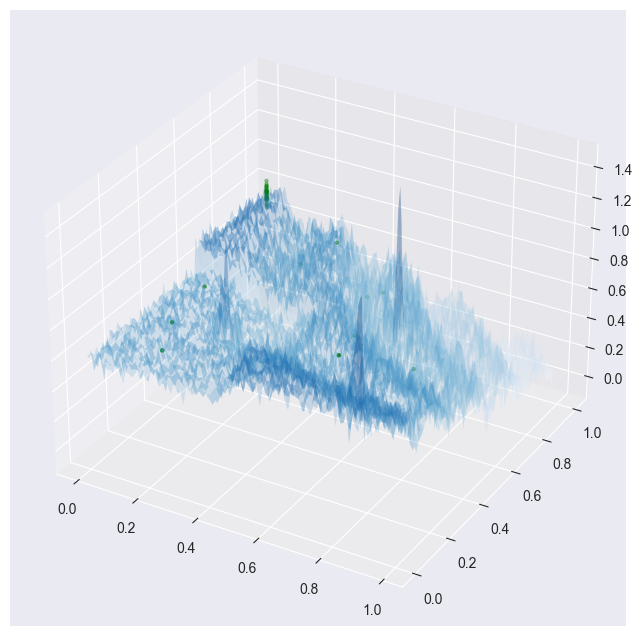

In [32]:
# plot evaluations for tead
x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0, alpha=0.2)
ax.scatter(train_x_nei[:,0].numpy(), train_x_nei[:,1].numpy(), train_obj_nei.numpy(), marker='.', color='g')
plt.savefig(datasavedir + '/'+'2d_mme_noise_tead_evals'+'.png')

In [18]:
X1.shape

torch.Size([100, 100])

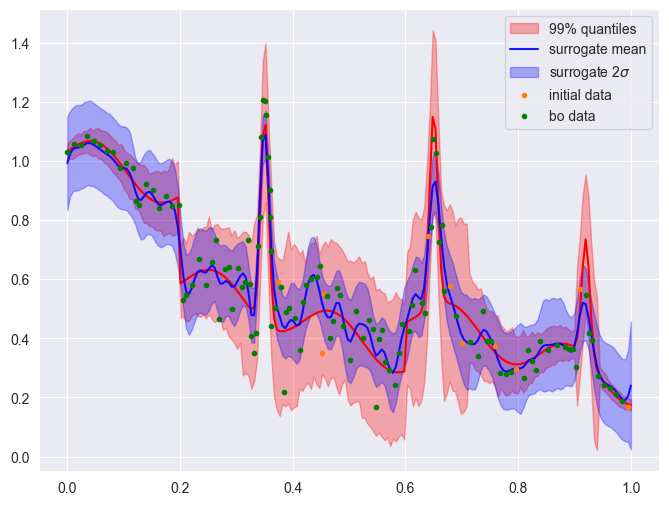

In [16]:
# plot the results for tead
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
# true objective
# ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# final model
mean_test = model_tead.posterior(x_test.unsqueeze(-1)).mean.detach().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
var_test = model_tead.posterior(x_test.unsqueeze(-1)).variance.detach().numpy()
sd_test = np.sqrt(var_test)
upper_test = mean_test + 2.0*sd_test
lower_test = mean_test - 2.0*sd_test
ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
# training points
ax.plot(train_x_tead.numpy()[0:10], train_obj_tead[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_tead.numpy()[10:], train_obj_tead[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
None

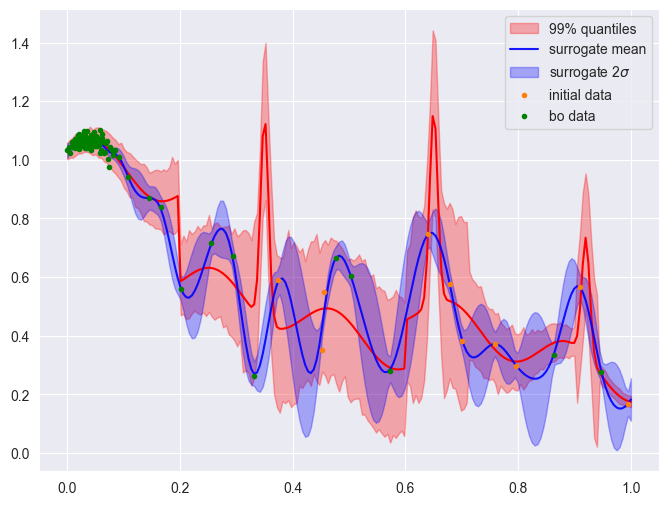

In [17]:
# plot the results for nei
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
# true objective
# ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# final model
mean_test = model_nei.posterior(x_test.unsqueeze(-1)).mean.detach().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
var_test = model_nei.posterior(x_test.unsqueeze(-1)).variance.detach().numpy()
sd_test = np.sqrt(var_test)
upper_test = mean_test + 2.0*sd_test
lower_test = mean_test - 2.0*sd_test
ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
# training points
ax.plot(train_x_nei.numpy()[0:10], train_obj_nei[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_nei.numpy()[10:], train_obj_nei[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
None

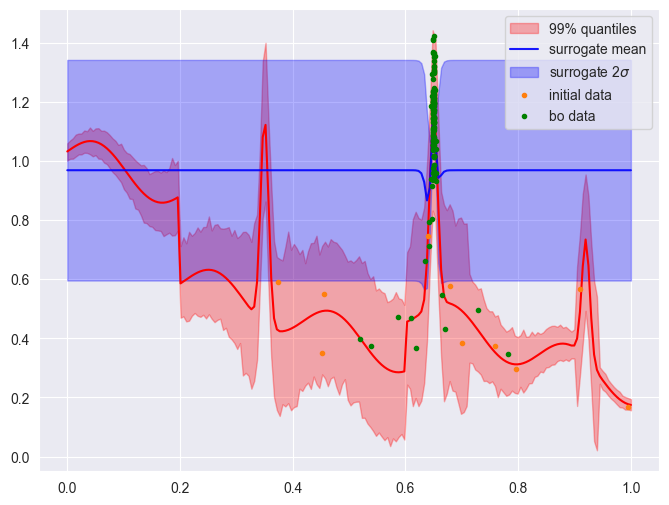

In [18]:
# plot the results for turbo
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# final model
mean_test = model_turbo.posterior(x_test.unsqueeze(-1)).mean.detach().numpy()
ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
var_test = model_turbo.posterior(x_test.unsqueeze(-1)).variance.detach().numpy()
sd_test = np.sqrt(var_test)
upper_test = mean_test + 2.0*sd_test
lower_test = mean_test - 2.0*sd_test
ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
# training points
ax.plot(train_x_turbo.numpy()[0:10], train_obj_turbo[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_turbo.numpy()[10:], train_obj_turbo[10:].numpy(), '.', color='g', label='bo data')
ax.legend()
None

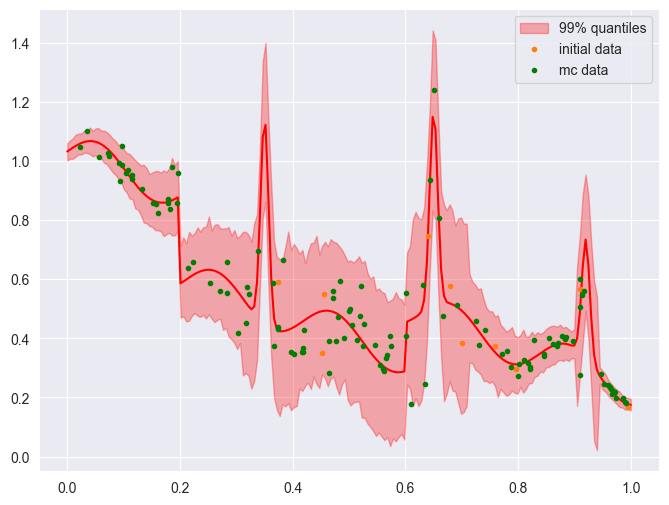

In [19]:
# plot the results for random
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# training points
ax.plot(train_x_random.numpy()[0:10], train_obj_random[0:10].numpy(), '.', color='tab:orange', label='initial data')
ax.plot(train_x_random.numpy()[10:], train_obj_random[10:].numpy(), '.', color='g', label='mc data')
ax.legend()
None

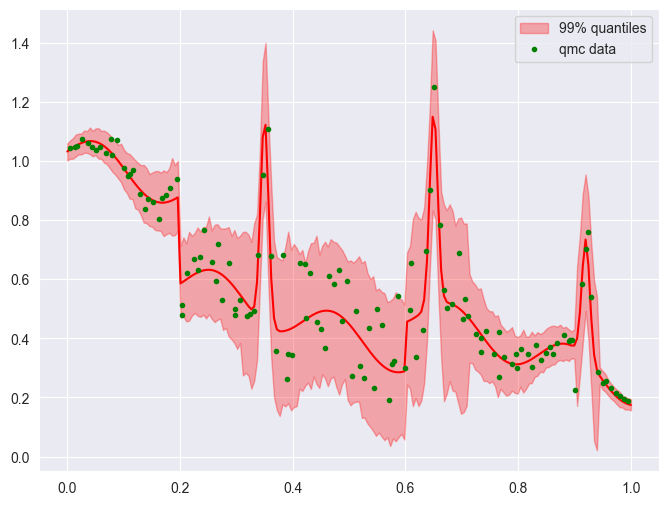

In [20]:
# plot the results for qmc
x_test = torch.linspace(0,1,200)
f, ax = plt.subplots(1,1, figsize=(8, 6))
# true objective
sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
# training points
ax.plot(X_Sobol.numpy(), Y_Sobol.numpy(), '.', color='g', label='qmc data')
ax.legend()
None

In [21]:
# algorithms for multi-modal optimization metrics
def count_number_peaks_observed(x_obs, y_obs, num_known_peaks=4):
    """Function to count the number of peaks observed for the mme_noise_jump_1d function"""
    peak1, peak2, peak3, peak4 = False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.03 <= x <= 0.07:
            if y >= 1.065:
                peak1 = True
        elif 0.345 <= x <= 0.355:
            if y >= 1.12:
                peak2 = True
        elif 0.645 <= x <= 0.655:
            if y >= 1.145:
                peak3 = True
        elif 0.915 <= x <= 0.925:
            if y >= 0.734:
                peak4 = True
    num_peaks_observed = peak1 + peak2 + peak3 + peak4
    return num_peaks_observed

def count_evaluations_for_all_peaks(x_obs, y_obs):
    """Count the number of function evaluations before finding all peaks"""
    i = 0
    num_evals_for_all_peaks = x_obs.shape[0]
    peak1, peak2, peak3, peak4 = False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.03 <= x <= 0.07:
            if y >= 1.065:
                peak1 = True
        elif 0.345 <= x <= 0.355:
            if y >= 1.12:
                peak2 = True
        elif 0.645 <= x <= 0.655:
            if y >= 1.145:
                peak3 = True
        elif 0.915 <= x <= 0.925:
            if y >= 0.734:
                peak4 = True
        i += 1
        if peak1 and peak2 and peak3 and peak4:
            num_evals_for_all_peaks = i
            break
    return num_evals_for_all_peaks

In [22]:
# # calculate and print metrics
# x_sob, y_sob = X_Sobol, Y_Sobol
# x_nei, y_nei = train_x_nei, train_obj_nei
# x_ran, y_ran = train_x_random, train_obj_random
# x_tea, y_tea = train_x_tead, train_obj_tead
# x_tur, y_tur = train_x_turbo, train_obj_turbo
#
# print('Random: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_ran, y_ran),
#                                                                 evals=count_evaluations_for_all_peaks(x_ran, y_ran)))
# print('Sobol: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_sob, y_sob),
#                                                                evals=count_evaluations_for_all_peaks(x_sob, y_sob)))
# print('NEI: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_nei, y_nei),
#                                                                 evals=count_evaluations_for_all_peaks(x_nei, y_nei)))
# print('TuRBO: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_tur, y_tur),
#                                                                 evals=count_evaluations_for_all_peaks(x_tur, y_tur)))
# print('TEAD: peaks {num}, evaluations for all {evals}'.format(num=count_number_peaks_observed(x_tea, y_tea),
#                                                                 evals=count_evaluations_for_all_peaks(x_tea, y_tea)))